In [ ]:
import pandas as pd
from urllib.parse import urlparse
import re

df = pd.read_json('matched_pairs.json')  # or read_json

professional = {'www.bbc.com','www.reuters.com','www.cnn.com','www.nbcnews.com','apnews.com'}
digital      = {'www.huffpost.com','www.buzzfeed.com','allrecipes.com','dailymail.co.uk'}

def get_publisher_type(url):
    dom = urlparse(url).netloc.lower()
    if dom in professional: return 'traditional'
    if dom in digital:      return 'digital-native'
    return 'other'

df['news_url'] = df['news_url'].fillna('').astype(str)
df['publisher_type'] = df['news_url'].apply(get_publisher_type)

parts = df['click_title'].str.split(r'\s*\|\s*', expand=True, n=1)
df['headline']     = parts[0]
df['spoiler_text'] = parts[1].fillna('')

def spoiler_type(txt):
    if re.search(r'\b1\.', txt):      return 'multi'
    if len(txt.split('.')) > 2:       return 'passage'
    return 'phrase'

df['spoiler_type'] = df['spoiler_text'].apply(spoiler_type)

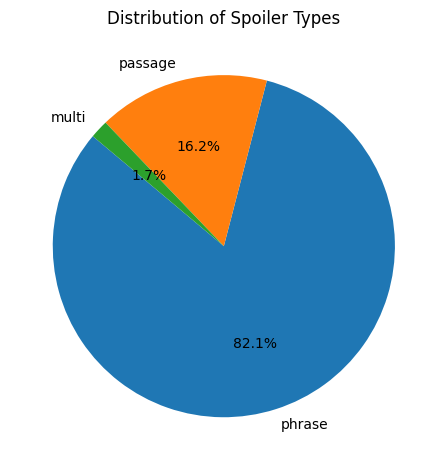

In [ ]:
import matplotlib.pyplot as plt

spoiler_counts = df['spoiler_type'].value_counts()
spoiler_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Spoiler Types")
plt.ylabel("")
plt.tight_layout()
plt.show()

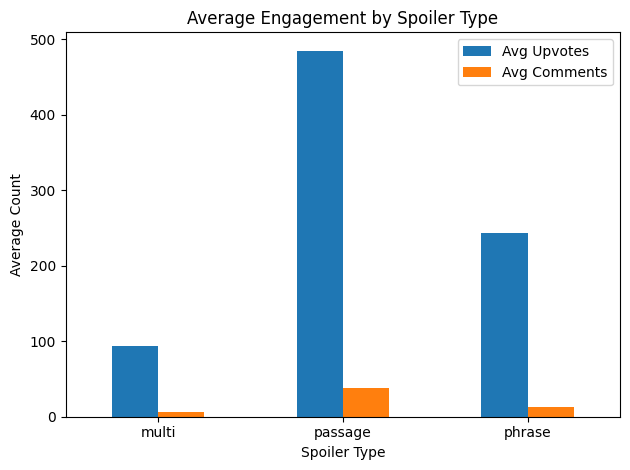

In [ ]:
eng = df.groupby('spoiler_type')[['click_score','click_comments']].mean()
eng.rename(columns={'click_score':'Avg Upvotes','click_comments':'Avg Comments'}, inplace=True)
eng.plot(kind='bar')
plt.title("Average Engagement by Spoiler Type")
plt.xlabel("Spoiler Type")
plt.ylabel("Average Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
comments = pd.read_json('click_comments.json')

if 'score' in comments.columns:
    comments = comments.rename(columns={'score':'sentiment_score'})

print(comments.columns.tolist())
print(comments[['spoiler_type','sentiment_score']].head())

['click_id', 'publisher_type', 'spoiler_type', 'sentiment_score', 'num_comments', 'comment_id', 'comment_body', 'comment_score', 'created_utc']
  spoiler_type  sentiment_score
0       phrase              797
1       phrase              797
2       phrase              797
3       phrase              797
4       phrase              797


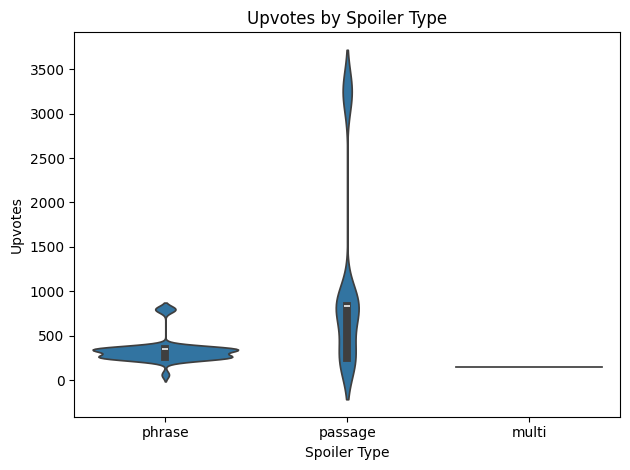

In [22]:
sns.violinplot(x='spoiler_type', y='sentiment_score', data=comments)
plt.title("Upvotes by Spoiler Type")
plt.xlabel("Spoiler Type")
plt.ylabel("Upvotes")
plt.tight_layout()
plt.show()

In [14]:
# Engagement = average post score & average comment sentiment
post_eng = df.groupby('spoiler_type')[['click_score', 'click_comments']].mean()
comment_eng = comments.groupby('spoiler_type')['comment_score'].mean()

print("Post engagement:\n", post_eng)
print("Comment sentiment score:\n", comment_eng)

Post engagement:
               click_score  click_comments
spoiler_type                             
multi           93.000000        6.000000
passage        484.660110       38.119972
phrase         243.060153       12.588025
Comment sentiment score:
 spoiler_type
multi       6.375000
passage    12.260870
phrase      9.438547
Name: comment_score, dtype: float64


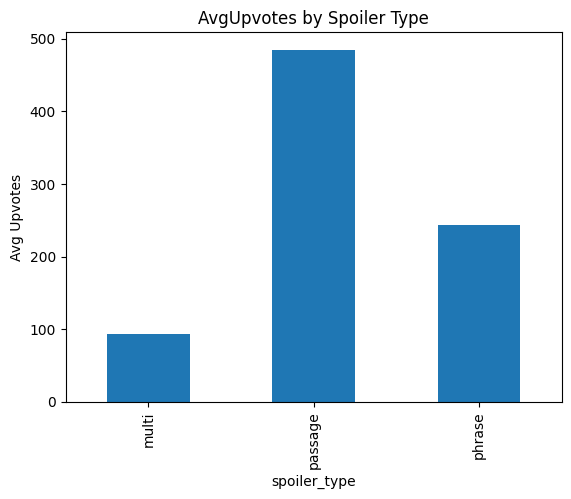

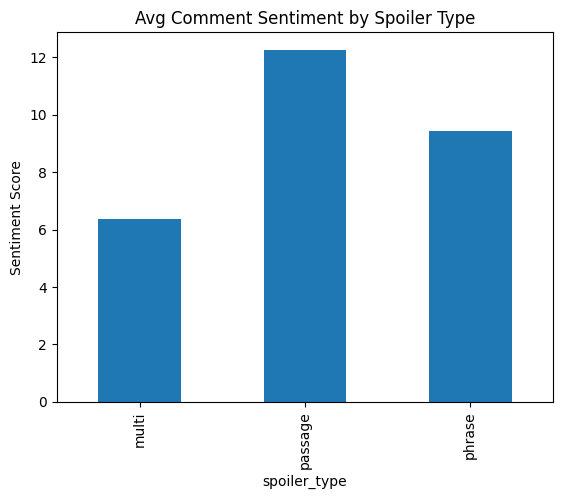

In [ ]:
import matplotlib.pyplot as plt

post_eng['click_score'].plot(kind='bar', title="AvgUpvotes by Spoiler Type")
plt.ylabel("Avg Upvotes")
plt.show()

comment_eng.plot(kind='bar', title="Avg Comment Sentiment by Spoiler Type")
plt.ylabel("Sentiment Score")
plt.show()

In [16]:
from scipy.stats import f_oneway

# e.g. compare comment_score distributions across spoiler types
groups = [comments.loc[comments.spoiler_type==t, 'score'] for t in comments.spoiler_type.unique()]
fstat, pval = f_oneway(*groups)
print(f"ANOVA F={fstat:.3f}, p={pval:.3e}")

ANOVA F=9.282, p=9.591e-05
